<a href="https://colab.research.google.com/github/ancestor9/2025_Winter_Deep-Learning-with-TensorFlow/blob/main/20260107_03_Image%20Classification/14_1_image_representation_for_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# LFW 데이터셋 로드
ds = tfds.load('lfw', split='train', shuffle_files=True)

In [ ]:
# 데이터셋에서 이미지 하나 가져오기
for example in ds.take(0):
    image = example['image']

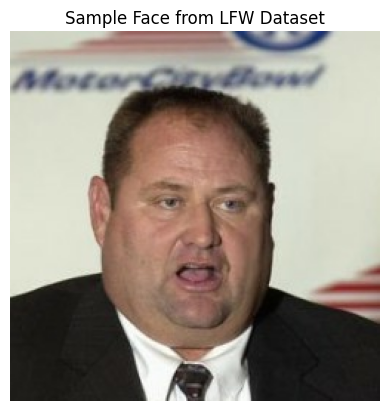

In [ ]:
# 데이터셋에서 이미지 하나 가져오기
for example in ds.take(1): # ds.take(0) 대신 ds.take(1)을 사용하여 실제 이미지를 가져옵니다.
    image = example['image']

# 이미지 시각화
plt.imshow(image)
plt.title('Sample Face from LFW Dataset')
plt.axis('off')
plt.show()

In [ ]:
image.shape

TensorShape([250, 250, 3])

### 1. 이미지 채널 줄이기

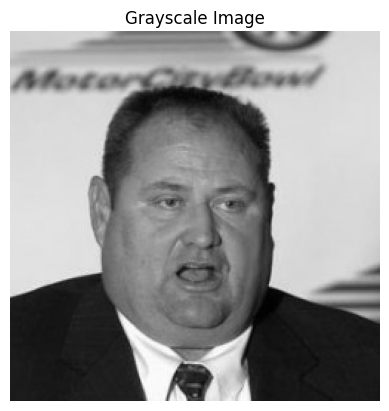

(250, 250, 1)


In [ ]:
import tensorflow as tf

# Convert the image to grayscale
image_grayscale = tf.image.rgb_to_grayscale(image)

# Visualize the grayscale image
plt.imshow(tf.squeeze(image_grayscale), cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

# Print the shape of the grayscale image
print(image_grayscale.shape)

In [ ]:
# Remove the channel dimension using tf.squeeze
image_grayscale_squeezed = tf.squeeze(image_grayscale)

# Print the shape of the squeezed image
print(image_grayscale_squeezed.shape)

(250, 250)


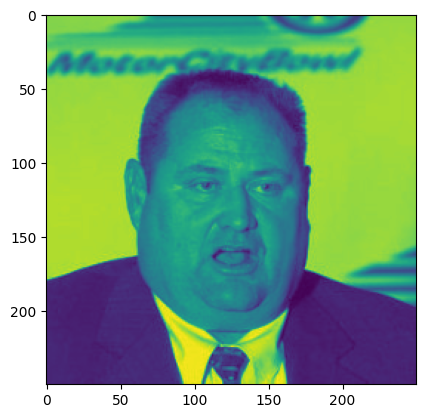

In [ ]:
plt.imshow(image_grayscale_squeezed)

In [ ]:
image_grayscale_squeezed.shape

TensorShape([250, 250])

### **2. 180도 이미지 회전하기**
- 180도 선형변환하는 행렬을 찾아 이미지 파일에 내적하면..

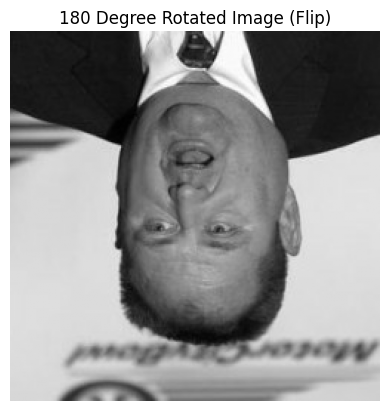

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# The AffineTransform2D op expects a transformation matrix of shape [N, 2, 3]
# where N is the batch size. The matrix represents a mapping from the output
# coordinates to the input coordinates.
# For a simple 2D rotation without translation, the matrix would be:
# [[cos(theta), -sin(theta), 0],
#  [sin(theta),  cos(theta), 0]]
# However, tf.raw_ops.AffineTransform2D applied the inverse transformation.
# So we need the matrix that maps input coordinates to output coordinates.
# [[cos(theta), sin(theta), 0],
#  [-sin(theta),  cos(theta), 0]]
# For 180 degrees (theta = pi), cos(pi) = -1, sin(pi) = 0. The matrix is:
# [[-1,  0, 0],
#  [ 0, -1, 0]]

# Reshape the grayscale image for the transformation function (add batch and channel dimensions)
image_transformed_input = tf.expand_dims(tf.expand_dims(image_grayscale_squeezed, axis=-1), axis=0)

# Create the transformation matrix for tf.raw_ops.AffineTransform2D
# The shape is [N, 2, 3]
# For 180 degree rotation: [[-1, 0, 0], [0, -1, 0]] for a single image (N=1)
transformation_matrix = tf.constant([
    [[-1.0, 0.0, 0.0],
     [0.0, -1.0, 0.0]]
], dtype=tf.float32)


# Apply the affine transformation using tf.raw_ops.Transform if available,
# or use a different approach like tf.keras.layers.Permute if applicable,
# or potentially reconstruct the image from transformed coordinates if necessary.
# Since tf.raw_ops.AffineTransform2D is not available, let's try a different approach.

# A simpler approach for 180 degree rotation on a square image is to flip it
# both horizontally and vertically. Add channel dimension back before flipping.
image_with_channel = tf.expand_dims(image_grayscale_squeezed, axis=-1)
image_rotated_linear = tf.image.flip_left_right(image_with_channel)
image_rotated_linear = tf.image.flip_up_down(image_rotated_linear)

# Visualize the rotated image
plt.imshow(tf.squeeze(image_rotated_linear), cmap='gray')
plt.title('180 Degree Rotated Image (Flip)')
plt.axis('off')
plt.show()

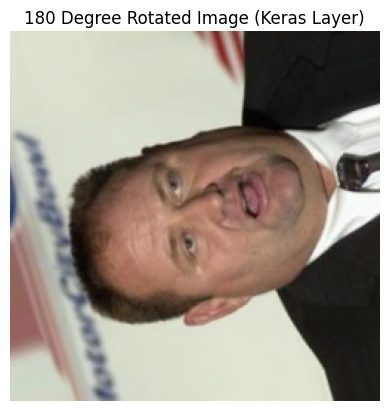

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure the image is in the correct format (add batch dimension)
# tf.keras.layers expects batched input
image_rotated_keras_input = tf.expand_dims(image, axis=0)

# Create a RandomRotation layer for 180 degrees (pi radians)
# The factor is the range of rotation angles in radians. For a fixed angle, set it to that angle.
# Since factor is a range, setting it to pi means rotating by a random angle between -pi and pi.
# To get exactly 180 degrees, we might need a different approach or set a very small range around pi.
# Let's try setting factor to 1.0 for now, which means a range of [-pi, pi].
# The fill_mode and interpolation arguments are similar to the previous function.
rotation_layer = tf.keras.layers.RandomRotation(
    factor=1.0, # Rotate by a random angle in [-pi, pi]
    fill_mode='nearest',
    interpolation='bilinear'
)

# Apply the rotation layer
image_rotated_keras = rotation_layer(image_rotated_keras_input)

# Remove the batch dimension for visualization
image_rotated_keras = tf.squeeze(image_rotated_keras, axis=0)

# Convert to numpy array for matplotlib display (ensure correct dtype)
# The output of RandomRotation might be float32, so convert to uint8 for image display
image_rotated_keras_display = tf.cast(image_rotated_keras, dtype=tf.uint8).numpy()


# Visualize the rotated image
plt.imshow(image_rotated_keras_display)
plt.title('180 Degree Rotated Image (Keras Layer)')
plt.axis('off')
plt.show()

### **3. 가로 이미지만 탐색 추출**

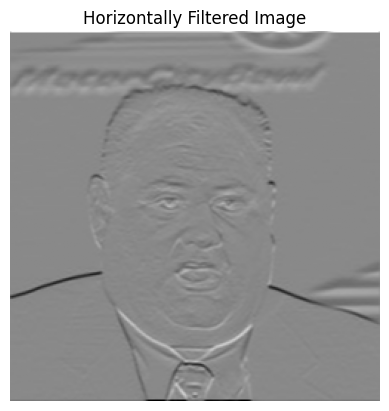

In [ ]:

# Define a horizontal Sobel filter kernel
horizontal_sobel = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)
horizontal_sobel = tf.reshape(horizontal_sobel, [3, 3, 1, 1]) # Reshape for convolution

# Add a channel dimension to the squeezed image for convolution
image_grayscale_expanded = tf.expand_dims(image_grayscale_squeezed, axis=-1)
image_grayscale_expanded = tf.cast(image_grayscale_expanded, dtype=tf.float32) # Cast to float32

# Apply the filter using convolution
filtered_image = tf.nn.conv2d(
    tf.expand_dims(image_grayscale_expanded, axis=0), # Add batch dimension
    horizontal_sobel,
    strides=[1, 1, 1, 1],
    padding='SAME'
)

# Remove the batch dimension and visualize the filtered image
filtered_image = tf.squeeze(filtered_image, axis=0)
plt.imshow(tf.squeeze(filtered_image), cmap='gray')
plt.title('Horizontally Filtered Image')
plt.axis('off')
plt.show()

### 4. Convolution 행렬

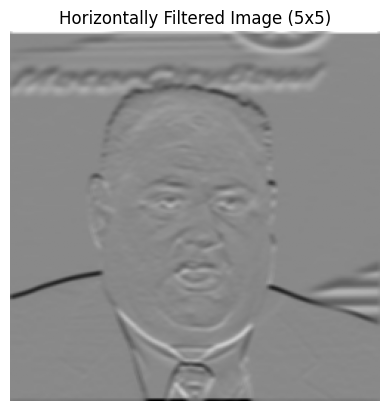

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define a 5x5 horizontal filter kernel
horizontal_filter_5x5 = tf.constant([
    [-1, -1, -2, -1, -1],
    [-1, -1, -2, -1, -1],
    [0, 0, 0, 0, 0],
    [1, 1, 2, 1, 1],
    [1, 1, 2, 1, 1]
], dtype=tf.float32)
horizontal_filter_5x5 = tf.reshape(horizontal_filter_5x5, [5, 5, 1, 1]) # Reshape for convolution

# Ensure the image is in the correct format (float32 and expanded dimensions)
image_for_filtering = tf.cast(tf.expand_dims(image_grayscale_squeezed, axis=-1), dtype=tf.float32)
image_for_filtering = tf.expand_dims(image_for_filtering, axis=0) # Add batch dimension

# Apply the filter using convolution
filtered_image_5x5 = tf.nn.conv2d(
    image_for_filtering,
    horizontal_filter_5x5,
    strides=[1, 1, 1, 1],
    padding='SAME'
)

# Remove the batch dimension and visualize the filtered image
filtered_image_5x5 = tf.squeeze(filtered_image_5x5, axis=0)
plt.imshow(tf.squeeze(filtered_image_5x5), cmap='gray')
plt.title('Horizontally Filtered Image (5x5)')
plt.axis('off')
plt.show()

### 5. Pooling 행렬 (sampling)

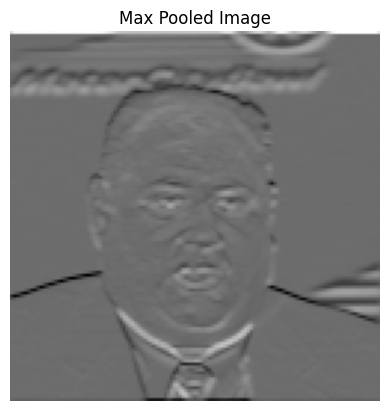

(125, 125, 1)


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Apply max pooling with a 2x2 pool size and stride of 2
pooled_image = tf.nn.max_pool(
    tf.expand_dims(filtered_image_5x5, axis=0), # Add batch dimension
    ksize=[1, 2, 2, 1],
    strides=[1, 2, 2, 1],
    padding='VALID'
)

# Remove the batch dimension and visualize the pooled image
pooled_image = tf.squeeze(pooled_image, axis=0)
plt.imshow(tf.squeeze(pooled_image), cmap='gray')
plt.title('Max Pooled Image')
plt.axis('off')
plt.show()

# Print the shape of the pooled image
print(pooled_image.shape)